# Проект. Прогнозирование тональной окраски комментариев
## Глава 0. Входные данные

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Требуется модель со значением метрики качества *F1* не меньше 0.75. 


### Описание данных

Признаки:  
- `text` — текст комментария  

Целевой признак:
- `toxic` — оценка токсичности комментария (1 - да, 0 - нет)

## Глава 1. Загрузка и подготовка данных

Вызовем основные библиотеки, необходимые для реализации проекта

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from sklearn.metrics import f1_score
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from tqdm import notebook
import torch
import transformers as ppb
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл, создадим ДатаФрейм, выведем таблицу:

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv') # для загрузки из облака
except:
    df = pd.read_csv('C:/Users/Vladislav/Downloads/toxic_comments.csv') # локально
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv') # google colab
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Выведем информацию о таблице через метод `.info()`:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Видно,что датасет состоит только из двух столбцов: комментариев и предварительной разметки. Комментарии содержатся в виде непредобработанного текста, которым нам предстоит заняться. Также, видно, что пропуски отсутствуют, это существенно облегчит задачу обучения моделей.

Посмотрим на распределение целевого признака

 Распределение целевого признака 


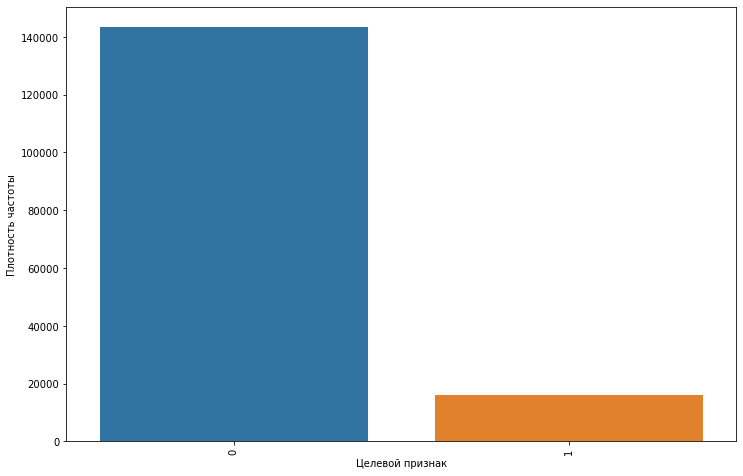

In [4]:
print('\033[1m Распределение целевого признака \033[0m')
fig, ax = plt.subplots(figsize=(12, 8))
plt.xticks(rotation=90)
sns.countplot(df['toxic'])
plt.xlabel('Целевой признак')
plt.ylabel('Плотность частоты')
plt.show()

In [5]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Присутствует дисбаланс в целевом признаке. Количество токсичных комментариев значительно меньше. Необходимо это учеть при обучении моделей.

Прежде чем извлечь признаки из текста, упростим его.  
Воспользуемся Лемматизацией — приведение слова к начальной форме

In [6]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Для того, чтобы найти правильный POS-тег для каждого слова, сопоставим его с правильным входным символом, который принимает WordnetLemmatizer, и передадим его в качестве второго аргумента в lemmatize().  
В nltk для этого есть метод nltk.pos_tag(). Он принимает список слов, а возвращает кортеж с тегом POS. Ключевым моментом здесь является сопоставление POS-тегов NLTK с форматом, принятым лемматизатором wordnet.

In [7]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [8]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])      
    return lemm_text

In [9]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

Проверим, что функции работают корректно на тексте первой строке обучающей выборки:

In [10]:
df.loc[0, 'text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
lemmatize(clear_text(df.loc[0, 'text']))

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

Проведем лемматизацию для всего столбца:

In [12]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: lemmatize(clear_text(text)))

Wall time: 1h 8min 20s


(здесь приведен код для импорта данных в основной датафрейм после дополнительного прогона, чтобы не запускать код лемматизации заново. чтобы получить полный датафрейм заново необходимо раскомментировать ячейку выше)

In [13]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/lemm_toxic_comments.csv')#google colab
#df = pd.read_csv('lemm_toxic_comments.csv')#локально

In [14]:
df.sample(10)

,text,toxic,lemm_text
117706,"Again, my edits references the struggle for th...",0,again my edits reference the struggle for the ...
158424,"Hello Ellibirdfly \n\nHello Ellibirdfly, \n\nI...",0,hello ellibirdfly hello ellibirdfly i make som...
127294,Modern Usage \n\nMaybe someone can add how han...,0,modern usage maybe someone can add how hang in...
88478,"""\nI believe I may have found some more inform...",0,i believe i may have found some more informati...
116163,"""\n\nJust being a nice Wikipedian to inform yo...",0,just be a nice wikipedian to inform you that i...
140760,Here is the timeline:\n15:42 I post summary on...,0,here be the timeline i post summary on an i po...
46916,Thats good enough for me; I removed the tag. L...,0,thats good enough for me i remove the tag look...
4155,The Description of the page is ad! \n\nWhy the...,0,the description of the page be ad why the desc...
133141,"""\n\nLike I said, there is nothing more to tal...",0,like i say there be nothing more to talk about...
23777,"""\n\n No notation on """"I Need You?"""" \n\nYou e...",0,no notation on i need you you editor do not kn...


Для того, чтобы сохранить результаты лемматизации и не запускать снова трудоемкий процесс, сохраним в csv и будем использовать его.

In [15]:
df.to_csv('lemm_toxic_comments.csv', index=False)

In [16]:
df = pd.read_csv('lemm_toxic_comments.csv')

Разделим датафрейм на 2 части: обучающую и тестовую выбороки в пропорциях 4:1  

In [17]:
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=17)

In [18]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((119678,), (39893,), (119678,), (39893,))

Создададим корпуса слов для обучающей и тестовой выборок:

In [19]:
train_corpus = train_features.values.astype('U')
test_corpus = test_features.values.astype('U')

Чтобы почистить мешок слов, найдём стоп-слова. Используем stopwords

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vladislav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stop_words = set(stopwords.words('english'))

### TF-IDF для корпуса текстов

Создадим счётчик, указав в нём стоп-слова, вызовем функцию `.fit_transform()` для обучающей выборки и `.transform()` для тестовой:

In [22]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(train_corpus)
test_tf_idf = count_tf_idf.transform(test_corpus)

Выведем размеры получившихся матриц:

In [23]:
print("Размер обучающей матрицы:", train_tf_idf.shape), 
print("Размер тестовой матрицы:", test_tf_idf.shape)

Размер обучающей матрицы: (119678, 128432)
Размер тестовой матрицы: (39893, 128432)


Напишем функцию `scoring(fitted_model)` для определения метрики f1_score для тестовой выбороки:

In [24]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(test_tf_idf)
    test_f1 = f1_score(test_target, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

### Выводы:

- В данных присутствовал дисбаланс целевого признака
- NLTK библиотека позволила преобразоваться тексты в векторный вид, пригодный для обучения моделей.
- TF-IDF существенно увеличил количество признаков, равное количеству в мешке слов.

## Глава 2. Обучение моделей

Обучим несколько моделей и оценим полученные результаты.  

Стратегия кросс-валидации для подбора параметров:

In [25]:
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=17)

### Логистическая регрессия

Инициализируем модель, сразу отметив в аргументах необходимость учета баланса классов

In [26]:
log_reg = LogisticRegression(random_state=17, class_weight='balanced')

Чтобы предсказание было более точным, выберем параметры, от которых зависит модель регресси, которые будут меньтся при обучении регрессии при поиске оптимальной настройки модели. Для регрессии таких параметров не так много, в данном случае используем подбор силы регуляризации. Чем меньше значения С тем сильнее регуляризация. Этот параметр полезен при борьбе с переобучением.

In [27]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

Найдём оптимальные настройки модели и обучим её

In [28]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(train_tf_idf, train_target)

Wall time: 2min 5s


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=17),
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             scoring='f1')

за 2 минуты модель обучилась и подобрала оптимальные настроки для предсказания. Взглянем на них

In [29]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 11.1112}
best scores:  0.7597108133196329


In [30]:
log_reg_grid.best_estimator_

LogisticRegression(C=11.1112, class_weight='balanced', random_state=17)

Оценка F1_score: 

In [31]:
%%time
scoring(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.761
Wall time: 16 ms


В результате получили значение F1 метрики на тестовой выборке 0,759. Это очень хороший результат, более того, он проходит пороговое значение, установленное заданием. Далее сравним результаты регрессии с другими моделями для определения лучшей

###  XGBClassifier

Проверим модель бустинга XGBClassifier. Данная модель по умолчанию учитывает возможный дисбаланс классов, поэтому дополнительных аргументов к инициализации не потребуется

In [32]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1)

Данная модель обычно тратит много времени на обучение и предсказания, чтобы не затягивать этот процесс, в качестве настраеваемого параметра выберем лишь один, в данном случае это количество "оценщиков".

In [33]:
xgb_clf_params = {'n_estimators': [100, 500]}

Запустим подбор параметров и обучение модели. Как и в случае с регрессией, определять лучшую модель будем по метрике F1, что указано соответствующим аргументом

In [34]:
%%time
xgb_clf_grid = GridSearchCV(xgb_clf, xgb_clf_params, scoring='f1')
xgb_clf_grid.fit(train_tf_idf, train_target)

[17:40:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:41:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, random_state=17,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=No

Как уже упоминалось ранее, эта модель обучается ощутимо дольше, в нашем случае 10 мин 28 сек, что в 5 раз превышает аналогичное время для модели регрессии. Взглянем на результаты подбора параметров

In [35]:
print('best parameters: ', xgb_clf_grid.best_params_)
print('best scores: ', xgb_clf_grid.best_score_)

best parameters:  {'n_estimators': 500}
best scores:  0.7644941021550233


In [36]:
xgb_clf_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Оценка F1_score: 

In [37]:
%%time
scoring(xgb_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.775
Wall time: 835 ms


Оценка контролируемой метрики на тестовой выборке составила  0.775, что, пусть не существенно, но, тем не менее, лучше значения полученного моделью регрессии. Несмотря на это, стоит учитывать ощутимо большее время на обучение модели 

### LGBMClassifier

Последней моделью для проверки будет LGBMClassifier. Аналогично предыдущим, учтем дисбаланс классов соответствующим аргументом при инициализации модели.

In [38]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17, class_weight='balanced')

Так как данная модель работает быстрее предыдущей, зададим большее количество параметров для настроек. Для данной задачи выбраны количество "оценщиков" и коэффициент обучения.

In [39]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [40]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(train_tf_idf, train_target)

Wall time: 11min 57s


GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', random_state=17),
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'n_estimators': [500]},
             scoring='f1')

В результате перебора большего количества настроек время обучения, по сравнению с предыдущими моделями, увеличилось до 11ти минут 45ти секунд. Взглянем на результаты настройки модели

In [41]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

best parameters:  {'learning_rate': 0.3, 'n_estimators': 500}
best scores:  0.7638517446786832


In [42]:
lgbm_clf_grid.best_estimator_

LGBMClassifier(class_weight='balanced', learning_rate=0.3, n_estimators=500,
               random_state=17)

Оценка F1_score: 

In [43]:
%%time
scoring(lgbm_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.769
Wall time: 834 ms


К сожалению, несмотря на большее количество параметров для настройки и большее время, затраченное на работу, модель дала предсказания несколько хуже предыдущего бустинга, но лучше регрессии. Стоит ли такой несущественный прирост настолько значительтного увеличения времени на обучение? Очень вряд-ли, особенно принимая во внимание результаты предыдщей модели.

### BERT

DistilBERT представляет собой уменьшенную версию BERT'а. Она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.

Загрузим предобученную модель DistilBERT и токенизатор:

In [44]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [45]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Выполним токенезацию исходных текстов:

In [47]:
%%time
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=df['text'].shape[0])))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Wall time: 3min 21s


Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512. Посчитаем длины текстов с токенами:

In [48]:
len_sentences = [len(i) for i in tokenized]

In [49]:
len_sentences = pd.Series(len_sentences)
len_sentences.describe()

count    159571.000000
mean         94.891860
std         141.438775
min           4.000000
25%          26.000000
50%          52.000000
75%         104.000000
max        4950.000000
dtype: float64

Видим, что есть аномально длинные. Ограничим тексты максимальной длиной токенов 75% квантилем.


In [50]:
indexes = []
for i in notebook.tqdm(range(len(tokenized))):
    if len(tokenized[i]) <= len_sentences.quantile(.75):
        indexes.append(i)

  0%|          | 0/159571 [00:00<?, ?it/s]

In [51]:
len(indexes)

119975

Полученные индексы "коротких" текстов применим к Датафрейму:

In [52]:
filtered_df = df.query('index in @indexes')

Размеры ДатаФрейма:

In [53]:
filtered_df.shape

(119975, 3)

Разделим датафрейм на 2 части: обучающую и тестовую выбороки в пропорциях по умолчанию:

In [54]:
filtered_df_train, filtered_df_test = train_test_split(filtered_df, random_state=17, test_size=5000)

In [55]:
filtered_df_train.shape, filtered_df_test.shape

((114975, 3), (5000, 3))

Для того, чтобы сбалансировать метки целевого признака в обучающей выборке, воспользуемся техникой downsampling 

Посмотрим на баланс классов

In [56]:
coef  = round((len(filtered_df_train[filtered_df_train['toxic'] == 1]) / 
               len(filtered_df_train[filtered_df_train['toxic'] == 0])), 3)
coef

0.127

Напишем функцию downsample(features, target, fraction) для формирования сблалансированной выборки:

In [57]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=17)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=17)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=17)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(filtered_df_train['text'], filtered_df_train['toxic'], coef)

In [58]:
features_downsampled.shape, target_downsampled.shape

((25946,), (25946,))

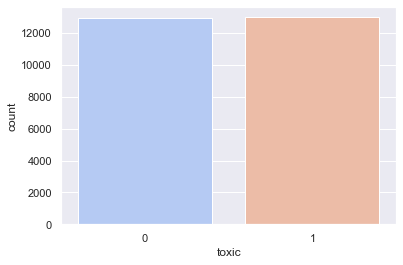

In [59]:
sns.set()
sns.countplot(target_downsampled, palette='coolwarm');

In [60]:
features_downsampled = pd.DataFrame(features_downsampled).reset_index(drop=True)
target_downsampled = pd.DataFrame(target_downsampled).reset_index(drop=True)
filtered_df_train = features_downsampled.join(target_downsampled)

In [61]:
filtered_df_train.shape, filtered_df_test.shape

((25946, 2), (5000, 3))

Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим (100). Обучающую выборку сделаем кратной размеру батча.

In [62]:
filtered_df_train = filtered_df_train[:25900]

Выполним токенезацию новых текстов:

In [63]:
%%time
tokenized_train = filtered_df_train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                    max_length=filtered_df_train['text'].shape[0])))

Wall time: 14.5 s


In [64]:
%%time
tokenized_test = filtered_df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                    max_length=filtered_df_test['text'].shape[0])))

Wall time: 2.97 s


Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. Только при таком условии будет работать модель BERT. 

In [65]:
def padding(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    return padded

padded_train = padding(tokenized_train)
padded_test = padding(tokenized_test)

In [66]:
np.array(padded_train).shape, np.array(padded_test).shape

((25900, 104), (5000, 104))

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание». Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [67]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_train.shape, attention_mask_test.shape

((25900, 104), (5000, 104))

Сделаем цикл по батчам. Отображать прогресс будет функция notebook()  
Преобразуем данные в формат тензоров  — многомерных векторов в библиотеке torch. Тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.  
Чтобы получить эмбеддинги для батча, передадим модели данные и маску  
Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.  
Из полученного тензора извлечём нужные элементы `batch_embeddings[0][:,0,:].numpy()` и добавим в список всех эмбеддингов  
Соберём все эмбеддинги в матрицу признаков вызовов функции `concatenate()`:

In [68]:
def embedings(padded, attention_mask):
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    features = np.concatenate(embeddings)
    return features

In [69]:
features_train = embedings(padded_train, attention_mask_train)

  0%|          | 0/259 [00:00<?, ?it/s]

In [70]:
features_test = embedings(padded_test, attention_mask_test)

  0%|          | 0/50 [00:00<?, ?it/s]

Целевые признаки:

In [71]:
labels_train = filtered_df_train['toxic']
labels_test = filtered_df_test['toxic']

In [72]:
def scoring_BERT(fitted_model):
    test_pred = fitted_model.predict(features_test)
    test_f1 = f1_score(labels_test, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

#### BERT для LogisticRegression:

In [73]:
log_reg = LogisticRegression(random_state=17)

In [74]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [75]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(features_train, labels_train)

Wall time: 1min 11s


GridSearchCV(estimator=LogisticRegression(random_state=17),
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             scoring='f1')

In [76]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 77.77780000000001}
best scores:  0.9010585818745757


In [77]:
log_reg_grid.best_estimator_

LogisticRegression(C=77.77780000000001, random_state=17)

Оценка F1_score: 

In [78]:
%%time
scoring_BERT(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.690
Wall time: 14 ms


#### BERT для   XGBClassifier

In [79]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=500)

In [80]:
%%time
xgb_clf.fit(features_train, labels_train)

[18:34:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 52s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Оценка F1_score: 

In [81]:
scoring_BERT(xgb_clf)

F1 на тестовой выборке: 0.676


#### BERT для   LGBMClassifier

In [82]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17)

In [83]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [84]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(features_train, labels_train)

Wall time: 6min 10s


GridSearchCV(estimator=LGBMClassifier(random_state=17),
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'n_estimators': [500]},
             scoring='f1')

In [85]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

best parameters:  {'learning_rate': 0.3, 'n_estimators': 500}
best scores:  0.8976347288712795


In [86]:
lgbm_clf_grid.best_estimator_

LGBMClassifier(learning_rate=0.3, n_estimators=500, random_state=17)

Оценка F1_score: 

In [87]:
%%time
scoring_BERT(lgbm_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.669
Wall time: 52.9 ms


#### Проверка модели на вменяемость
Для того, чтобы получить «случайные» результаты, воспользуемся DummyClassifier. Полученные им результаты абсолютно случайные.  

In [88]:
dummy_clf = DummyClassifier()

In [89]:
scores = cross_val_score(dummy_clf, features_train, labels_train, scoring='f1')
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.667 (+/- 0.00)


In [90]:
dummy_clf.fit(features_train, labels_train)

DummyClassifier()

Оценка F1_score: 

In [91]:
scoring_BERT(dummy_clf)

F1 на тестовой выборке: 0.208


Видим что в среднем модель предсказывает гораздо хуже рассмотренных выше моделей.

### Выводы:

В процессе обучения моделей обнаружили по TF-IDF:
- Почти все модели показали значение f1 в районе 0.77.
- Лучшей по метрики f1 является модель XGBClassifier
- Лучшей по времени обучения Логистическая Регрессия

В процессе обучения моделей по BERT:
- Почти все модели показали значение f1 в районе 0.67
- Лучшей также является Логистическая Регрессия c результатом 0.69

## Глава 3. Анализ моделей и общий вывод

Проанализируем все модели на качество предсказания, скорость обучения

Сведем все данные в таблицу:

In [92]:
df1 = pd.DataFrame({'Модель':['LogisticRegression', 'XGBClassifier', 'LGBMClassifier'], 
        'Скорость обучения по TF-IDF':['2 мин', '10 мин 28 сек', '11 мин 45 сек'],
        'Скорость обучения по BERT':['1 мин', '3 мин 37 сек', '4 мин 14 сек'],
        'Качество предсказания по TF-IDF': [0.759, 0.775, 0.769],
        'Качество предсказания по BERT': [ 0.690, 0.676, 0.669]})

In [93]:
df1

,Модель,Скорость обучения по TF-IDF,Скорость обучения по BERT,Качество предсказания по TF-IDF,Качество предсказания по BERT
0,LogisticRegression,2 мин,1 мин,0.759,0.690
1,XGBClassifier,10 мин 28 сек,3 мин 37 сек,0.775,0.676
2,LGBMClassifier,11 мин 45 сек,4 мин 14 сек,0.769,0.669


### Общий вывод:

 По результатам исследований моделей для поставленной задачи наиболее оптимальными являются:
- LogisticRegression и предподготовкой текста с помощью BERT для решения задачи с максимальной скоростью
- XGBClassifier и предподготовкой текста с помощью TF-IDF для решения задачи с макисмальной точностью
